# 8 Job search with on-the-job search

In [13]:
!pip install --upgrade quantecon
!pip install interpolation

Requirement already up-to-date: quantecon in /Users/shuhu/anaconda3/lib/python3.7/site-packages (0.4.5)


In [14]:
import numpy as np
import scipy.stats as stats
from interpolation import interp
from numba import njit, prange
import matplotlib.pyplot as plt
%matplotlib inline
from math import gamma

# 1 Overview

We will solve a simple on-the-job search model, based on two sources.

## 1.1 Model features

1. Job-specific human capital accumulation combined with on-the-job search.
2. Infinite-horizon dynamic programming with one state variable and two controls.

# 2 Model

## 2.1 Setting ups (*?*)

1. Let

   - $x_t$ denote the time-$t$ job-specific human capital of a worker employed at a given firm.
   - $w_t$ denote current wages.

2. Let $w_t = x_t (1- s_t - \phi_t)$, where

   - $\phi_t$: investment in job-specific human capital for the current role.
   - $s_t$: search effort, devoted to obtaining new offers from other firms.

3. For as long as the worker remains in the current job, evolution of $\{x_t \}$ is given by $x_{t+1}= g(x_t , \phi)$.

4. When search effort at $t$ is $s_t$, the worker receives a new job offer with probability $\pi(s_t) \in [0,1]$.

5. Value of offer is $u_{t+1}$, where $\{u_t\}$ is iid with common distribution $f$.

6. Worker has the right to reject the current offer and continue with existing job.

7. In particular, $x_{t+1} = u_{t+1}$ if accepts and $x_{t+1} = g(x_t, \phi_t)$ if rejects.

8. Let $b_{t+1} \in \{0, 1\}$ be binary with $b_{t+1}=1$ indicating an offer, we can write
   $$
   x_{t+1} = ( 1- b_{t+1}) g(x_t, \phi_t) + b_{t+1} \max \{ g(x_t, \phi_t), u_{t+1} \} \tag{1}
   $$

9. Agent's objective: maximize expected discounted sum of wages via controls $\{ s_t \}$ and $\{ \phi_t\}$.

## 2.2 Model

Taking the expectation of $v(x_{t+1})$ and using [(1)](#), the Bellman equation for this problem can be written as
$$
v(x) = \max_{s + \phi} \{  x(1 - s - \phi) + \beta (1- \pi (s)) v[g(x, \phi)] + \beta \pi (s) \int v[g(x, \phi) \vee u] f(du)\} \tag{2}
$$
Here, nonnegativity of $s$ and $\phi$ is known, and $a \vee b = \max \{a,b\}$.

## 2.3 Parameterization

Let 
$$
g(x , \phi) = A(x \phi)^{\alpha}, \ \pi(s) = \sqrt{s} \ and \ f =Beta (2,2)
$$
with paremeter values

$A = 1.4$;

$\alpha = 0.6$;

$\beta= 0.96$.

The $Beta (2,2)$ distribution is supported on $(0,1)$, which has a unimodal, symmetric density peaked at $0.5$.

## 2.4 Back-of-the-Envelope Calculations

1. Since the worker has two instruments to build capital and hence wages:
   - Invest in capital specific to the current job via $\phi$.
   - search for a new job with better job-specific capital match via $s$.

2. Since wages are $x_t (1- s_t - \phi_t)$, marginal cost of investment via either $\phi$ or $s$ is identical.
   - Our risk-neutral worker should focus on whatever instrument has the highest expected return.
   - The relative expected return will depend on $x$.
     - Suppose $x=0.05$.
       - If $s=1$ and $\phi=0$, then since $g(x , \phi)=0$, taking expectations of [(1)](#) gives expected next period capital equal to $\pi (s) \mathbb Eu= \mathbb E u = 0.5$.
       - If $s= 0$ and $\phi =1$, then next period capital is $g(x, \phi) = g(0.05, 1) \approx 0.23$.
       - Both rates of return are good, but the return from search is better.
     - Suppose $x =0.4$.
       - If $s=1$ and $\phi=0$, then the expected next period capital is again $0.5$.
       - If $s= 0$ and $\phi =1$, then $g(x, \phi) = g(0.4, 1) \approx 0.8$.
       - return from investment via $\phi$ dominates expected return from search.
     - Combining these observations gives us two informal predictions:
       - At any given state $x$, the two controls $\phi$ and $s$ will function primarily as substitutes.
         -  Workers will focus on whichever instrument has the higher expected return.
       - For sufficiently small $x$, search will be preferable to investment in job-specific human capital. For larger $x$, the reverse will be true.



# 3 Implementation

Step 1: Set up a class *JVWorker* that holds the parameters of the model.

In [15]:
class JVWorker:
    def __init__(self,
                A=1.4,
                α = 0.6,
                β = 0.96,
                π = np.sqrt,
                a = 2,
                b = 2, 
                grid_size = 50,
                mc_size = 100,
                ϵ = 1e-4):
        self.A, self.α, self.β, self.π = A, α, β, π
        self.mc_size, self.ϵ = mc_size, ϵ
        
        self.g = njit(lambda x, ϕ: A * (x * ϕ)**α) # g(x, ϕ)
        self.f_rvs = np.random.beta(a, b, mc_size)
        
        ## What is grid_max? Why we need it? (It is the max of a large quantile value for f and fixed point y= g(y, l)? How to understand it?)
        ϵ = 1e-4 
        grid_max = max(A**(1 / (1 - α)), stats.beta(a, b).ppf( 1 - ϵ))
        
        ## What is x_grid? Why we need it? (Human Capital?)
        self.x_grid = np.linspace(ϵ, grid_max, grid_size)

Step 2: Similar to previous lecture, we define a function *operator factor* that takes an instance of this class and returns a jitted version of the Bellman operator *T* and another function *get_greedy* that returns the optimal policies of *s* and $\phi$, given a value function.

1. The Bellman operator *T* is a transitional function such that
$$
Tv(x) = \max_{s + \phi \leq 1} w(s, \phi)
$$
 - where
 $$
 w(s, \phi) = x(1 - s - \phi) + \beta ( 1- \pi (s)) v[g(x, \phi )] +  \beta \pi(s) \int v[g(x, \phi) \vee u ] f(du) \tag{3}
 $$
2. When we represent v, it will be with a NumPy array *v*, giving values on grid *x_grid*. (?)

3. In order to evaluate the RHS of [(3)](#), we need to replace the array *v* and *x_grid* with a function *v_func* that gives linear interpolation of *v* on *x_grid*. (?)

4. Inside the *for* loop, for each *x* in the grid over the state space, we set up the function $w (z) = w(s , \phi) $ defined in [(3)](#). (?) This function is maximized over all feasible $(s, \phi)$ pairs.


In [16]:
def operator_factory(jv, parallel_flag=True):
    # use values stored in jv
    π, β = jv.π, jv.β
    x_grid, ϵ, mc_size = jv.x_grid, jv.ϵ, jv.mc_size
    f_rvs, g = jv.f_rvs, jv.g
    
    @njit
    def objective(z, x, v):
        s, ϕ = z # what is  ? Why we need it?
        # what is v_func ? Why we need it? See above 2 & 3
        v_func = lambda x: interp(x_grid, v, x)
        
        integral = 0
        for m in range(mc_size):
            u = f_rvs[m]
            integral += v_func(max(g(x, ϕ), u))
        integral = integral / mc_size
        
        q = π(s) * integral + ( 1- π(s)) * v_func(g(x, ϕ))
        return x * ( 1 - ϕ - s) + β * q # w(s, ϕ)
    
    @njit(parallel=parallel_flag)
    def T(v):
        """
        compute the maximum of a given function w(s, ϕ)
        """
        v_new = np.empty_like(v)
        for i in prange(len(x_grid)):
            x = x_grid[i]
            search_grid = np.linspace(ϵ, 1, 15)
            max_val = -1
            
            # find the max_val of w(s, ϕ) as w(z)=v_new
            for s in search_grid:
                for ϕ in search_grid:
                    current_val = objective((s, ϕ), x, v) if s + ϕ <= 1 else -1
                    if current_val > max_val:
                        max_val = current_val
            v_new[i] = max_val
        return v_new
    
    @njit
    def get_greedy(v):
        """
        computes the v_greedy policy of a given function v
        (maximizers for the maximium)
        """
        s_policy, ϕ_policy = np.empty_like(v), np.empty_like(v)
        
        for i in range(len(x_grid)):
            x = x_grid[i]
            search_grid = np.linspace(ϵ, 1, 15)
            max_val = -1
            for s in search_grid:
                for ϕ in search_grid:
                    current_val = objective((s, ϕ), x, v) if s + ϕ <= 1 else -1
                    if current_val > max_val:
                        max_val = current_val
                        max_s, max_ϕ = s, ϕ
                        s_policy[i], ϕ_policy[i] = max_s, max_ϕ
        return s_policy, ϕ_policy
    return T, get_greedy
    

Step 3: To solve the model, we write a function that uses the Bellman operator and iterates it to find a fixed point.

In [17]:
def solve_model(jv,
               use_parallel=True,
               tol=1e-4,
               max_iter = 1000,
               verbose=True,
               print_skip=25):
    T, _ = operator_factory(jv, parallel_flag = use_parallel)
    
    v = jv.x_grid * 0.5 # why 0.5?
    i = 0
    error = tol + 1
    while i < max_iter and error > tol:
        v_new = T(v)
        error = np.max(np.abs(v - v_new))
        i += 1
        if verbose and i % print_skip == 0:
            print(f"Error at iteration {i} is {error}.")
        v = v_new
    
    if i == max_iter:
        print("Failed to converge!")
    
    if verbose and i < max_iter:
        print(f"\nConverged in {i} iterations.")
        
    return v_new

# 4 Solving for policies


Error at iteration 25 is 0.15111290742063765.
Error at iteration 50 is 0.05446059568350492.
Error at iteration 75 is 0.019627419882469965.
Error at iteration 100 is 0.00707365768603907.
Error at iteration 125 is 0.0025493230062281214.
Error at iteration 150 is 0.0009187676416591017.
Error at iteration 175 is 0.00033112084161146527.
Error at iteration 200 is 0.00011933486420012684.

Converged in 205 iterations.


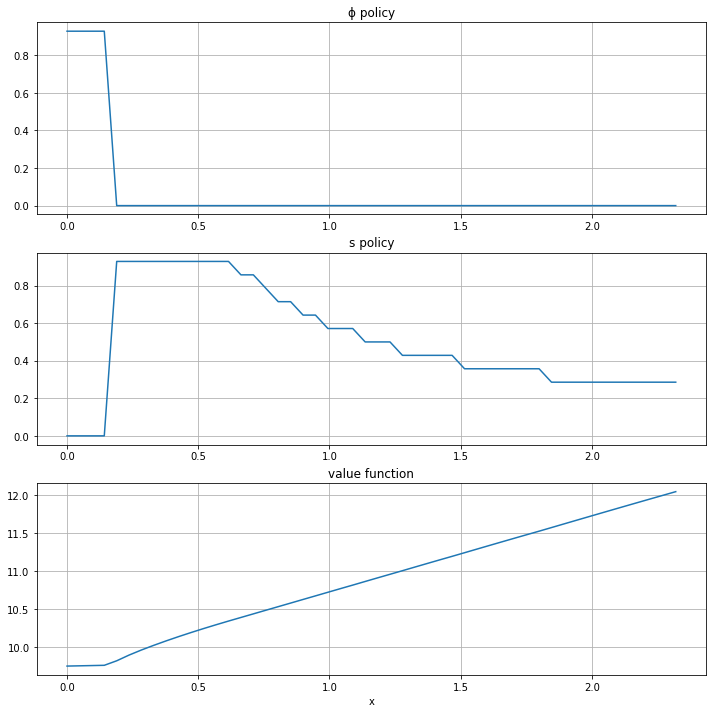

In [18]:
jv = JVWorker()
T, get_greedy = operator_factory(jv)
v_star = solve_model (jv)
s_star, ϕ_star = get_greedy(v_star)
plots = [s_star, ϕ_star, v_star]
titles = ["ϕ policy", "s policy", "value function"]

fig, axes = plt.subplots(3, 1, figsize=(12, 12))

# What is this loop? Why?
for ax, plot, title in zip(axes, plots, titles): # What is zip? Why?
    ax.plot(jv.x_grid, plot)
    ax.set(title=title)
    ax.grid()
    
axes[-1].set_xlabel("x")
plt.show()
    

The horizontal axis is the state $x$ (job specific human capital), while the vertical axis gives $s(x)$ and $\phi (x)$.

Overall, the policies match well with our predictions in 2.4.
1. Worker switches from one investment strategy to the other, depending on relative return.
2. For low values of $x$, the best option is to search for a new job.
3. Once $x$ is larger, worker does better by investing in human capital specific to the current position.

# 5 Exercises and answers

## 5.1 Ex.1 (?)
Consider the dynamics for the state process $\{ x_t \}$ associated with these policies.

The dynamics are given by [(1)](#) when $\phi_t$ and $s_t$ are chosen according to the optimal policies, and $\mathbb P \{ b_{t+1} =1 \} = \pi (s_t)  $.

Since the dynamics are random, we can solve it by ploting, for each $x$ in a relatively fine grid called *plot_grid*, a large number $K$ of realizations of $x_{t+1}$, given $x_t = x$.

Plot this with one dot for each realization, in the form of a 45 degree diagram, setting

(0, 1.2)

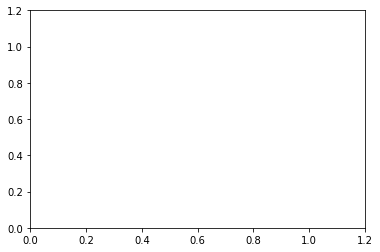

In [19]:
jv = JVWorker(grid_size=25, mc_size=50)



plot_grid_max, plot_grid_size = 1.2, 100
plot_grid = np.linspace(0, plot_grid_max, plot_grid_size)
fig, ax = plt.subplots()
ax.set_xlim(0, plot_grid_max)
ax.set_ylim(0, plot_grid_max)

By examing the plot, argue that under the optimal policies, the state $x_t$ will converge to a constant value $\bar x$ close to unity.

Argue that at the steady state, $s_t \approx 0 $ and $\phi_t \approx 0.6$.

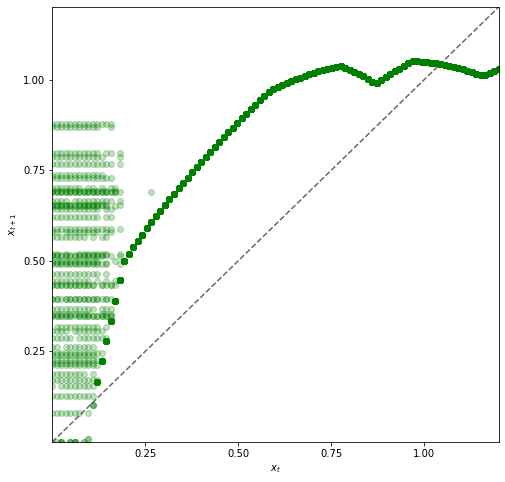

In [20]:
jv = JVWorker(grid_size=25, mc_size=50)
π, g, f_rvs, x_grid = jv.π, jv.g, jv.f_rvs, jv.x_grid
T, get_greedy = operator_factory(jv)
v_star = solve_model(jv, verbose=False)
s_policy, ϕ_policy = get_greedy(v_star)

# What this step? Why we need it?
s = lambda y: interp(x_grid, s_policy, y)
ϕ = lambda y: interp(x_grid, ϕ_policy, y)

def h(x, b, u):
    return (1 - b) * g(x, ϕ(x)) + b * max(g(x, ϕ(x)), u)

plot_grid_max, plot_grid_size = 1.2, 100
plot_grid = np.linspace(0, plot_grid_max, plot_grid_size)
fig, ax = plt.subplots(figsize=(8,8))
ticks = (0.25, 0.5, 0.75, 1.0)
ax.set(xticks=ticks, yticks=ticks,
       xlim=(0, plot_grid_max),
       ylim=(0, plot_grid_max),
       xlabel='$x_t$', ylabel='$x_{t+1}$')

ax.plot(plot_grid, plot_grid, 'k--', alpha=0.6)
for x in plot_grid:
    for i in range(jv.mc_size):
        b = 1 if np.random.uniform(0, 1) < π(s(x)) else 0
        u = f_rvs[i]
        y = h(x, b, u)
        ax.plot(x, y, 'go', alpha=0.25)
        
plt.show()

## 5.2 Ex.2
When the value of $\beta$ close to 1, $s_t \to 0$ and $\phi_t \to 0.6$ indicated in our last exercise.
Consider the case when the worker is infinitely patient (?What is it?).

Intuitively, an infinitely patient worker would like to maximise steady state wages, which are a function of steady state capital, that is, given taht the infinitely patient worker does not search in the long run (i.e., $s_t = 0$ for large $t$).

Thus, given $\phi$, steady state capital is the positive fixed point $x^* (\phi)$ of the map $x \to g(x, \phi)$, the steady state wages can be written as $w^* (\phi) = x^*(\phi)(1- \phi)$.

Graph $w^*(\phi)$ with respect to $\phi$, and examine the best choice of $\phi$. Give a rough interpretation for the value we see.

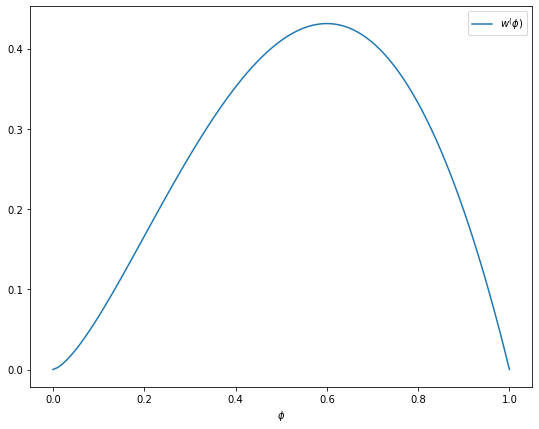

In [21]:
jv = JVWorker()

def xbar(ϕ): # how do we know that?
    A, α = jv.A, jv.α
    return (A * ϕ**α)**(1 / (1 - α)) # ?

ϕ_grid = np.linspace(0, 1, 100)  
fig, ax = plt.subplots(figsize=(9, 7))
ax.set(xlabel = '$\phi$')

# calculate and plot wbar
ax.plot(ϕ_grid, [xbar(ϕ) * ( 1- ϕ) for ϕ in ϕ_grid], label='$w^(\phi)$')
ax.legend()

plt.show()

The maximizer is around 0.6, which is similar to the long-run value for $\phi$ obtained in Ex.1.

Hence, the behavior of the infinitely patient worker is similar to that of the worker with $\beta =0.96$.

This seems reasonable and helps us confirm that our dynamic programming solutions are probably correct.